In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
#!unzip "/content/drive/MyDrive/sample_submission_v2.csv.zip" -d "/content/drive/MyDrive/label/"
#!unzip "" -d "/content/drive/MyDrive/label/"
#!unzip "" -d "/content/drive/MyDrive/label/"

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download nikitarom/planets-dataset -p datasets

planets-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
import sys
import os

from PIL import Image
from skimage import io, transform
from tqdm import tqdm

from zipfile import ZipFile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras  
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping

In [6]:
pwd

'/content'

In [18]:
ROOT = os.path.abspath("")

TRAIN_LABEL_CSV = os.path.join(ROOT, 'drive/MyDrive/label/train_map.csv')
TEST_LABEL_CSV = os.path.join(ROOT, 'drive/MyDrive/label/sample_submission_v2.csv')

TRAIN_JPEG_DIR = os.path.join(ROOT, 'drive/MyDrive/train-jpg.zip')
TEST_JPEG_DIR = os.path.join(ROOT, 'drive/MyDrive/test-jpg.zip')
TEST_ADD_JPEG_DIR = os.path.join(ROOT, 'drive/MyDrive/test-jpg-additional.zip')

In [20]:
train_df = pd.read_csv(TRAIN_LABEL_CSV)
test_df = pd.read_csv(TEST_LABEL_CSV)

In [39]:
train_df.shape, test_df.shape

((40479, 2), (61191, 2))

In [40]:
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [41]:
# Build list with unique labels
labels_df = train_df.copy()
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)


In [42]:
label_list

['haze',
 'primary',
 'agriculture',
 'clear',
 'water',
 'habitation',
 'road',
 'cultivation',
 'slash_burn',
 'cloudy',
 'partly_cloudy',
 'conventional_mine',
 'bare_ground',
 'artisinal_mine',
 'blooming',
 'selective_logging',
 'blow_down']

In [44]:
## Apply onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)


labels_df.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


In [45]:
labels_dict = dict(zip(range(0,17), label_list))
labels_dict

{0: 'haze',
 1: 'primary',
 2: 'agriculture',
 3: 'clear',
 4: 'water',
 5: 'habitation',
 6: 'road',
 7: 'cultivation',
 8: 'slash_burn',
 9: 'cloudy',
 10: 'partly_cloudy',
 11: 'conventional_mine',
 12: 'bare_ground',
 13: 'artisinal_mine',
 14: 'blooming',
 15: 'selective_logging',
 16: 'blow_down'}

In [87]:
import io as ioo

def img_reader(path, filename, img_size=(64,64)):
  
    imgpath = path.read(f'train-jpg/{filename}.jpg')
    imgdata = ioo.BytesIO(imgpath)
    img = io.imread(imgdata)
    img = transform.resize(img, img_size)
    return img

In [115]:
train_dir = '/content/drive/MyDrive/dataset/train-jpg.zip'   #'planet/planet/train-jpg'
test_dir = '/content/drive/MyDrive/dataset/test-jpg.zip' #'planet/planet/test-jpg'
test_add_dir ='/content/drive/MyDrive/dataset/test-jpg-additional.zip'  #'test-jpg-additional/test-jpg-additional'

(64, 64, 3)

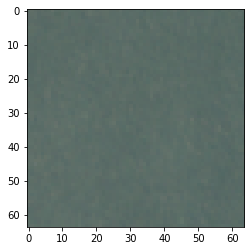

In [122]:
planet_zip = ZipFile(train_dir)
planet_zip1 = ZipFile(test_dir)
planet_zip2 = ZipFile(test_add_dir)

imgd = img_reader(planet_zip, "train_0")
plt.imshow(imgd)
imgd.shape

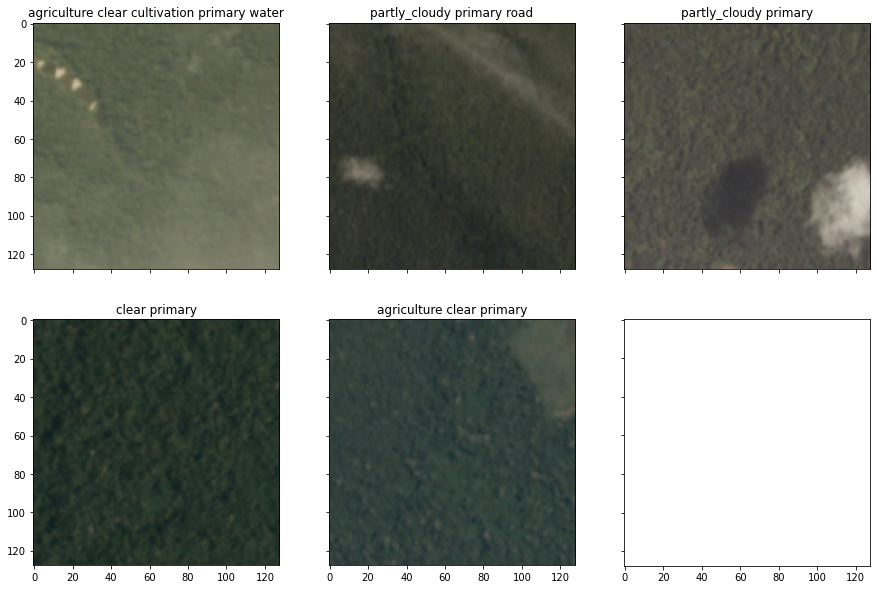

In [93]:
#display images
_, axs = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))
axs = axs.ravel()

for i, (img_name, label) in enumerate(train_df.sample(5).values):
    img = img_reader(planet_zip, img_name, (128, 128))
    axs[i].imshow(img)
    axs[i].set_title(f'{label}')

## Image Preprocessing

In [94]:
y_train = labels_df[label_list].values
y_train = np.array(y_train, np.uint8)
y_train.shape

(40479, 17)

In [95]:
input_size = 64

In [97]:
X_train = []
for img_name in tqdm(train_df["image_name"].values, miniters=1000):
    img = img_reader(planet_zip, img_name)
    X_train.append(img)

100%|██████████| 40479/40479 [10:07<00:00, 66.65it/s]


In [98]:
X_train = np.array(X_train, np.float16)
print(X_train.shape)

(40479, 64, 64, 3)


In [103]:
test_df[test_df.image_name == "file_0"]

,image_name,tags
40669,file_0,primary clear agriculture road water


In [104]:
n_test_img = 40669 #len(os.listdir(TEST_JPEG_DIR)) #I looked up the value
test_org = test_df.iloc[ :n_test_img]
test_add = test_df.iloc[n_test_img: ]

In [117]:
def img_reader2(path, filename, img_size=(64,64)):
  
    imgpath = path.read(f'test-jpg/{filename}.jpg')
    imgdata = ioo.BytesIO(imgpath)
    img = io.imread(imgdata)
    img = transform.resize(img, img_size)
    return img

In [118]:
X_test = []
for img_name in tqdm(test_org["image_name"].values, miniters=1000):
    img = img_reader2(planet_zip1, img_name)
    X_test.append(img)

100%|██████████| 40669/40669 [15:38<00:00, 43.33it/s]


In [123]:
def img_reader3(path, filename, img_size=(64,64)):
  
    imgpath = path.read(f'test-jpg-additional/{filename}.jpg')
    imgdata = ioo.BytesIO(imgpath)
    img = io.imread(imgdata)
    img = transform.resize(img, img_size)
    return img

In [124]:
for img_name in tqdm(test_add["image_name"].values, miniters=1000):
    img = img_reader3(planet_zip2, img_name)
    X_test.append(img)

100%|██████████| 20522/20522 [04:58<00:00, 68.66it/s]


In [125]:
X_test = np.array(X_test, np.float32)
print(X_test.shape)

(61191, 64, 64, 3)


In [126]:
#Normalize train
X_train = X_train / 255

In [127]:
#Normalize test
X_test = X_test / 255

In [128]:
# split the train data into train and validation data sets
Xtrain = X_train[ :37000]
ytrain = y_train[ :37000]

Xval = X_train[37000: ]
yval = y_train[37000: ]

## Model

In [129]:
# specify sizes (batch and model input) and number of input channels
input_size = 64
input_channels = 3
batch_size = 250

In [134]:
model = Sequential()

# Input layer
model.add(BatchNormalization(input_shape=(input_size, input_size, input_channels)))

# CCM_1
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


#CCM_2
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#CCM_3
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#CCM_4
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


# Create a feature vector from the CCM_4 final layer
model.add(Flatten())

# Fully Connected (FC) Layer
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer
model.add(Dense(17, activation='sigmoid'))

In [136]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 64, 64, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 64)        1

In [143]:
labels_freq.index = range(17)
total = 40479
class_weight = dict(labels_freq.apply(lambda x : (1 / x) * (total/100)))
class_weight

{0: 0.15008898776418242,
 1: 0.010790659238130782,
 2: 0.03286967113276492,
 3: 0.014237627941331644,
 4: 0.05462015922277696,
 5: 0.1105983606557377,
 6: 0.05015363647627308,
 7: 0.09041545677909314,
 8: 1.9367942583732058,
 9: 0.19377213977979896,
 10: 0.055748519487673884,
 11: 4.0479,
 12: 0.4695939675174014,
 13: 1.194070796460177,
 14: 1.2192469879518073,
 15: 1.1905588235294118,
 16: 4.130510204081633}

In [146]:
# Defining other parameters
epochs=10
lr = 0.0001
optimizer = keras.optimizers.Adam(learning_rate=lr)
batch_size = 250

In [138]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer, 
              metrics=["accuracy"])

early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=0)

In [1]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
          callbacks=[early_stop], validation_split=0.2,
          class_weight=class_weight)

NameError: ignored

In [ ]:
model.evaluate(X_train, y_train)

1265/1265 [==============================] - 18s 14ms/step - loss: 0.1674 - accuracy: 0.8267


[0.16738010942935944, 0.8267496824264526]

In [ ]:
model.save("model2/")

INFO:tensorflow:Assets written to: model2/assets


### Test Prediction

In [ ]:
model = keras.models.load_model("model2/")

In [ ]:
model

In [ ]:
def extract_classes(data_df, label_list=label_list):
    #data_df = data_df.applymap(lambda x : 1 if x > 0.5 else 0)
    for col in data_df.columns:
        if col == "primary":
            data_df[col] = data_df[col].apply(lambda x : 1 if x > 0.6 else 0)
        elif col == "clear":
            data_df[col] = data_df[col].apply(lambda x : 1 if x > 0.5 else 0)
        elif col == "agriculture" or col == "road" or col == "water" or col == "partly_cloudy":
            data_df[col] = data_df[col].apply(lambda x : 1 if x > 0.5 else 0)
        elif col == "haze" or col == "habitation" or col == "bare_ground" or col == "cloudy":
            data_df[col] = data_df[col].apply(lambda x : 1 if x > 0.5 else 0)
        else:
            data_df[col] = data_df[col].apply(lambda x : 1 if x > 0.2 else 0)
            
    preds = []
    for i in range(len(data_df.values)):
        temp = data_df.iloc[i]
        label = []
        for j in range(17):
            if temp[j] == 1:
                label.append(labels_dict[j])
        preds.append(" ".join(label))
    
    return preds

In [ ]:
def extract_classes2(data_df, label_list=label_list):
    for i in range(data_df.shape[0]):
        data_df.iloc[i, :] = data_df.iloc[i, :].apply(lambda x : 1 if x > data_df.iloc[i, :].mean() else 0)
            
    preds = []
    for i in range(len(data_df.values)):
        temp = data_df.iloc[i]
        label = []
        for j in range(17):
            if temp[j] == 1:
                label.append(labels_dict[j])
        preds.append(" ".join(label))
    
    return preds

In [ ]:
predictions = model.predict(X_test)

In [ ]:
preds_df = pd.DataFrame(predictions)
preds = extract_classes(preds_df)

In [ ]:
test_df['tags'] = preds
test_df.to_csv('submission_file.csv', index=False)

In [ ]:
test_df.head(10)

,image_name,tags
0,test_0,primary clear
1,test_1,primary agriculture clear
2,test_2,primary agriculture partly_cloudy
3,test_3,primary clear
4,test_4,cloudy
5,test_5,primary clear
6,test_6,haze primary agriculture clear water road cult...
7,test_7,primary agriculture clear water habitation road
8,test_8,primary clear
9,test_9,haze primary agriculture water


In [ ]:
test_df['tags'].value_counts()

primary clear                                                           21755
primary agriculture clear water road cultivation                         3591
primary agriculture clear water habitation road                          2052
cloudy                                                                   2044
haze primary cloudy                                                      1957
                                                                        ...  
haze primary agriculture clear road partly_cloudy                           1
primary agriculture clear water habitation cultivation partly_cloudy        1
primary water habitation road partly_cloudy                                 1
primary agriculture clear road cloudy                                       1
agriculture cloudy                                                          1
Name: tags, Length: 180, dtype: int64